# Valorant VCT Predictions

## Backstory
The first file I was able to create a model that can predict with up to 65% accuracy. Since then I learned quite a bit about data analytics and figured it would be easier to start fresh when training my next models.

Goal for this file is to get up to 70% accuracy and I will try to update the existing logistic regression model and explore different models, such as XGBoost

# Next Steps
Graphs are not looking as promising as earlier, I think what needs to be done next is to 
* greatly reduce the scope of the data
* Only look at a few teams
* make moving averages for each maps and make predictions on a map by map basis

The data leakage was a bit of a set back, but glad to have found it. Just need to be a bit more weary for the future.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

#get dataframes for each map and try looking for correlations/signals that can be used for each map
data = pd.read_csv('scrapy/vlrgg/playerData/vlr.csv')
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, "%d-%m-%y"))
data['playerHS'] = data['playerHS'].apply(lambda x: float(str(x).split('%')[0]))

In [7]:
#analysis for the map haven
num_cols =['playerKills',
       'playerDeaths', 'playerAssists', 'playerACS', 'playerADR', 'playerHS',
       'playerFirstBlood', 'playerFirstDeath']

haven_data = data

haven_data[num_cols] = haven_data.sort_values(by=['date', 'playerName']).groupby(['playerName'])[num_cols].rolling(5).mean().shift(1).reset_index(level=0, drop=True)

haven_data_avg = haven_data.copy()

In [10]:
haven_total = haven_data_avg.copy()
haven_total[num_cols] = haven_total.groupby(['gameID', 'playerTeam'])[num_cols].transform('sum')
haven_total = haven_total.drop_duplicates(subset=['gameID', 'playerTeam']).dropna()
haven_team_total = pd.DataFrame()
for games in haven_total['gameID'].unique():
    teams = haven_total[haven_total['gameID']==games]['playerTeam'].unique()
    matchData = haven_total[haven_total['gameID']==games]
    if len(teams)!=2:
        continue
    team1 = matchData[matchData['playerTeam']==teams[0]]
    team2 = matchData[matchData['playerTeam']==teams[1]]
    tempDict = {
           'playerTeam': teams[0],
           'map': team1['map'].values[0],
           'playerKills': team1['playerKills'].values[0],
           'playerDeaths': team1['playerDeaths'].values[0],
           'playerAssists': team1['playerAssists'].values[0],
           'playerACS': team1['playerACS'].values[0],
           'playerHS': team1['playerHS'].values[0],
           'playerADR': team1['playerADR'].values[0],
           'playerFirstBlood': team1['playerFirstBlood'].values[0],
           'playerFirstDeath': team1['playerFirstDeath'].values[0],
           'o_playerKills': team2['playerKills'].values[0],
           'o_playerDeaths': team2['playerDeaths'].values[0],
           'o_playerAssists': team2['playerAssists'].values[0],
           'o_playerACS': team2['playerACS'].values[0],
           'o_playerHS': team2['playerHS'].values[0],
           'o_playerADR': team2['playerADR'].values[0],
           'o_playerFirstBlood': team2['playerFirstBlood'].values[0],
           'o_playerFirstDeath': team2['playerFirstDeath'].values[0],
           'o_playerTeam': teams[1],
           'result': team1['result'].values[0]
    }
    haven_team_total = haven_team_total.append(tempDict, ignore_index=True)
haven_team_total

,map,o_playerACS,o_playerADR,o_playerAssists,o_playerDeaths,o_playerFirstBlood,o_playerFirstDeath,o_playerHS,o_playerKills,o_playerTeam,playerACS,playerADR,playerAssists,playerDeaths,playerFirstBlood,playerFirstDeath,playerHS,playerKills,playerTeam,result
0,Haven,1068.4,713.0,32.2,84.8,13.2,11.0,107.0,89.4,FS,968.4,665.2,30.2,65.4,10.4,9.8,134.0,69.0,VS,Win
1,Haven,1039.2,646.8,28.4,64.0,11.8,8.4,115.8,73.8,INF,1117.8,712.4,35.6,57.2,11.4,8.4,111.2,77.8,KRÜ,Win
2,Breeze,1048.6,712.2,32.4,83.0,13.2,10.2,111.6,85.6,FS,977.4,679.6,28.4,65.6,9.8,9.4,142.4,68.2,VS,Win
3,Breeze,979.8,654.0,32.4,77.0,11.8,11.2,142.6,80.0,GMB,1068.8,686.4,29.2,66.4,11.8,8.4,133.8,78.8,ACE,Lose
4,Ascent,1055.6,682.0,34.2,80.8,11.6,12.4,93.6,86.0,X10C,1079.4,676.4,31.2,68.0,11.0,10.4,107.0,80.0,VKS,Win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13957,Split,997.4,0.0,30.6,80.4,12.0,0.0,67.2,79.6,DWG,978.2,0.0,27.0,78.6,10.4,0.0,82.2,78.0,GE,Win
13958,Icebox,1050.4,718.4,17.8,62.4,10.2,9.2,158.4,72.4,SMB,978.4,659.4,21.0,88.2,11.0,12.4,157.6,82.0,FTBL,Win
13959,Icebox,993.4,675.6,28.4,89.2,12.4,13.6,143.6,88.2,FTBL,1030.2,701.4,22.2,76.2,11.8,10.4,135.8,82.0,G2,Lose
13960,Haven,828.4,542.4,19.6,75.8,8.8,10.2,123.8,59.6,OBG,1013.8,693.6,26.0,78.4,12.2,10.8,153.6,82.2,SMB,Win


<AxesSubplot:xlabel='playerDeaths', ylabel='o_playerDeaths'>

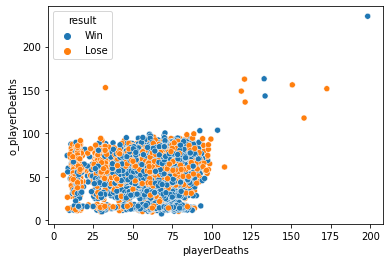

In [11]:
haven_team_total = haven_team_total.replace(0, np.nan)
haven_team_total = haven_team_total.dropna()
haven_team_total['kdRatio'] = haven_team_total.apply(lambda x: x['playerKills']/x['playerDeaths'], axis=1)
haven_team_total['o_kdRatio'] = haven_team_total.apply(lambda x: x['o_playerKills']/x['o_playerDeaths'], axis=1)
haven_team_total['fb_diff'] = haven_team_total.apply(lambda x: x['playerFirstBlood'] - x['playerFirstDeath'], axis=1)
haven_team_total['o_fb_diff'] = haven_team_total.apply(lambda x: x['o_playerFirstBlood'] - x['o_playerFirstDeath'], axis=1)
sns.scatterplot(data=haven_team_total, x='playerDeaths', y='o_playerDeaths', hue='result')

In [ ]:
haven_team_total.columns

Index(['map', 'o_playerACS', 'o_playerADR', 'o_playerAssists',
       'o_playerDeaths', 'o_playerFirstBlood', 'o_playerFirstDeath',
       'o_playerHS', 'o_playerKills', 'o_playerTeam', 'playerACS', 'playerADR',
       'playerAssists', 'playerDeaths', 'playerFirstBlood', 'playerFirstDeath',
       'playerHS', 'playerKills', 'playerTeam', 'result', 'kdRatio',
       'o_kdRatio', 'fb_diff', 'o_fb_diff'],
      dtype='object')

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

cat_col = ['playerTeam', 'o_playerTeam', 'result']
num_cols =['o_playerACS', 'o_playerADR','playerACS', 'playerADR','kdRatio',
'o_kdRatio', 'fb_diff', 'o_fb_diff', 'playerKills', 'o_playerKills','playerDeaths', 'o_playerDeaths']
modeldf = pd.get_dummies(haven_team_total[cat_col])
modeldf[num_cols] = haven_team_total[num_cols]

X_train, X_test, y_train, y_test = train_test_split(modeldf.drop(['result_Lose', 'result_Win'], axis=1), modeldf['result_Win'], test_size=0.25,random_state=123)
clf = LogisticRegression(random_state=13, max_iter=10000)
clf.fit(X_train, y_train)
print(confusion_matrix(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

[[ 634  493]
 [ 394 1147]]
0.6675412293853074


In [ ]:
#see how well this model can predict matches in the VCT masters or from more well known teams
